# Generative Adverserial Networks in PyTorch

Deep neural networks are used mainly for supervised learning: classification or regression. Generative Adverserial Networks or GANs, however, use neural networks for a very different purpose: Generative modeling

> Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset. - [Source](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/)


In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

8.9%

100.0%


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw


100.0%


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw




100.0%
100.0%


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [4]:
img, label = mnist[0]
print('Label: ', label)
print(img[0:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

In [11]:
def denorm(x):
    out = (x + 1) / 2
    #out = (x * 0.5) + 0.5
    return out.clamp(0, 1)

Label: 5


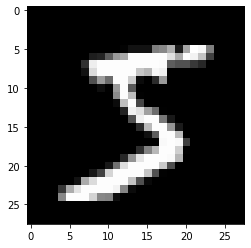

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
#print(img_norm[0])
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [13]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
torch.Size([28, 28])
tensor([5, 3, 1, 0, 1, 4, 9, 1, 0, 5, 0, 9, 9, 4, 7, 0, 1, 3, 7, 8, 7, 5, 3, 8,
        6, 9, 0, 7, 4, 6, 2, 9, 7, 0, 7, 9, 2, 3, 6, 9, 7, 5, 2, 7, 7, 1, 0, 4,
        1, 9, 3, 8, 4, 1, 1, 8, 5, 6, 0, 3, 4, 9, 0, 8, 3, 5, 5, 1, 6, 7, 1, 2,
        2, 1, 9, 1, 1, 1, 5, 0, 3, 0, 2, 1, 8, 8, 8, 5, 0, 9, 5, 2, 0, 5, 5, 0,
        6, 3, 5, 3])


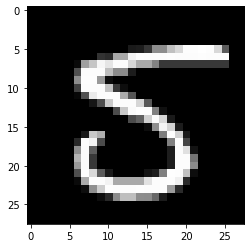

In [16]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    print(img_batch[0][0].shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [17]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
device

device(type='cuda')

## Discriminator Network

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. While we can use a CNN for the discriminator, we'll use a simple feedforward network with 3 linear layers to keep things since. We'll treat each 28x28 image as a vector of size 784.

In [19]:
image_size = 784
hidden_size = 256

In [20]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [21]:
D.to(device);

## Generator Network

The input to the generator is typically a vector or a matrix which is used as a seed for generating an image. Once again, to keep things simple, we'll use a feedfoward neural network with 3 layers, and the output will be a vector of size 784, which can be transformed to a 28x28 px image.

In [22]:
latent_size = 64

In [23]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [27]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

torch.Size([2, 28, 28])


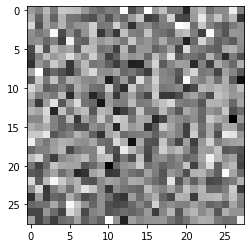

In [31]:
plt.imshow(gen_imgs[0], cmap='gray');

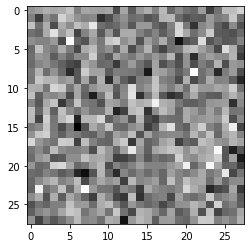

In [32]:
plt.imshow(gen_imgs[1], cmap='gray');

In [33]:
G.to(device);

In [34]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [35]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

In [36]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [37]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

## Training the Model

In [38]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

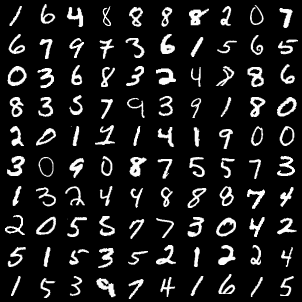

In [39]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


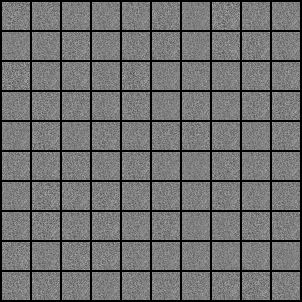

In [40]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [41]:
len(data_loader)

600

In [42]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0686, g_loss: 3.8075, D(x): 0.99, D(G(z)): 0.05
Epoch [0/300], Step [400/600], d_loss: 0.0467, g_loss: 6.5433, D(x): 0.98, D(G(z)): 0.02
Epoch [0/300], Step [600/600], d_loss: 0.0515, g_loss: 5.0961, D(x): 0.99, D(G(z)): 0.04
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0802, g_loss: 4.6715, D(x): 0.98, D(G(z)): 0.06
Epoch [1/300], Step [400/600], d_loss: 0.5778, g_loss: 2.4509, D(x): 0.77, D(G(z)): 0.08
Epoch [1/300], Step [600/600], d_loss: 0.3252, g_loss: 3.3568, D(x): 0.95, D(G(z)): 0.21
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.3428, g_loss: 2.9149, D(x): 0.85, D(G(z)): 0.11
Epoch [2/300], Step [400/600], d_loss: 0.1178, g_loss: 3.8611, D(x): 0.95, D(G(z)): 0.06
Epoch [2/300], Step [600/600], d_loss: 0.4748, g_loss: 2.8155, D(x): 0.80, D(G(z)): 0.12
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.1019, g_loss: 4.9677, D(x): 0.95, D(G(z)): 0.03
Epoch [3/300], Step [400/6

Epoch [27/300], Step [600/600], d_loss: 0.3396, g_loss: 5.8755, D(x): 0.91, D(G(z)): 0.09
Saving fake_images-0028.png
Epoch [28/300], Step [200/600], d_loss: 0.1780, g_loss: 4.8709, D(x): 0.94, D(G(z)): 0.06
Epoch [28/300], Step [400/600], d_loss: 0.2523, g_loss: 4.6247, D(x): 0.97, D(G(z)): 0.08
Epoch [28/300], Step [600/600], d_loss: 0.5434, g_loss: 2.5210, D(x): 0.91, D(G(z)): 0.18
Saving fake_images-0029.png
Epoch [29/300], Step [200/600], d_loss: 0.2436, g_loss: 4.2139, D(x): 0.91, D(G(z)): 0.05
Epoch [29/300], Step [400/600], d_loss: 0.3294, g_loss: 4.0349, D(x): 0.92, D(G(z)): 0.11
Epoch [29/300], Step [600/600], d_loss: 0.3083, g_loss: 3.4040, D(x): 0.93, D(G(z)): 0.13
Saving fake_images-0030.png
Epoch [30/300], Step [200/600], d_loss: 0.5132, g_loss: 2.6148, D(x): 0.95, D(G(z)): 0.26
Epoch [30/300], Step [400/600], d_loss: 0.2004, g_loss: 4.5292, D(x): 0.92, D(G(z)): 0.08
Epoch [30/300], Step [600/600], d_loss: 0.3363, g_loss: 4.5557, D(x): 0.85, D(G(z)): 0.03
Saving fake_imag

Epoch [55/300], Step [400/600], d_loss: 0.5932, g_loss: 2.5834, D(x): 0.85, D(G(z)): 0.25
Epoch [55/300], Step [600/600], d_loss: 0.4038, g_loss: 2.3021, D(x): 0.90, D(G(z)): 0.21
Saving fake_images-0056.png
Epoch [56/300], Step [200/600], d_loss: 0.4852, g_loss: 2.0949, D(x): 0.86, D(G(z)): 0.20
Epoch [56/300], Step [400/600], d_loss: 0.4854, g_loss: 2.7196, D(x): 0.81, D(G(z)): 0.14
Epoch [56/300], Step [600/600], d_loss: 0.6767, g_loss: 2.7061, D(x): 0.83, D(G(z)): 0.23
Saving fake_images-0057.png
Epoch [57/300], Step [200/600], d_loss: 0.5313, g_loss: 3.5281, D(x): 0.82, D(G(z)): 0.15
Epoch [57/300], Step [400/600], d_loss: 0.5880, g_loss: 2.1383, D(x): 0.79, D(G(z)): 0.18
Epoch [57/300], Step [600/600], d_loss: 0.5503, g_loss: 3.0105, D(x): 0.81, D(G(z)): 0.13
Saving fake_images-0058.png
Epoch [58/300], Step [200/600], d_loss: 0.8694, g_loss: 2.3008, D(x): 0.71, D(G(z)): 0.18
Epoch [58/300], Step [400/600], d_loss: 0.6708, g_loss: 2.8107, D(x): 0.76, D(G(z)): 0.14
Epoch [58/300], 

Epoch [83/300], Step [200/600], d_loss: 0.7759, g_loss: 2.0710, D(x): 0.78, D(G(z)): 0.25
Epoch [83/300], Step [400/600], d_loss: 0.8584, g_loss: 1.7163, D(x): 0.74, D(G(z)): 0.22
Epoch [83/300], Step [600/600], d_loss: 0.5453, g_loss: 2.4743, D(x): 0.86, D(G(z)): 0.24
Saving fake_images-0084.png
Epoch [84/300], Step [200/600], d_loss: 0.7056, g_loss: 2.3212, D(x): 0.83, D(G(z)): 0.31
Epoch [84/300], Step [400/600], d_loss: 0.9892, g_loss: 1.0044, D(x): 0.81, D(G(z)): 0.41
Epoch [84/300], Step [600/600], d_loss: 0.6466, g_loss: 2.2727, D(x): 0.79, D(G(z)): 0.24
Saving fake_images-0085.png
Epoch [85/300], Step [200/600], d_loss: 1.0536, g_loss: 2.1252, D(x): 0.72, D(G(z)): 0.33
Epoch [85/300], Step [400/600], d_loss: 0.7547, g_loss: 2.7026, D(x): 0.73, D(G(z)): 0.16
Epoch [85/300], Step [600/600], d_loss: 0.7581, g_loss: 2.6522, D(x): 0.71, D(G(z)): 0.17
Saving fake_images-0086.png
Epoch [86/300], Step [200/600], d_loss: 0.8815, g_loss: 1.7615, D(x): 0.76, D(G(z)): 0.32
Epoch [86/300], 

Epoch [110/300], Step [600/600], d_loss: 0.9270, g_loss: 1.4776, D(x): 0.68, D(G(z)): 0.26
Saving fake_images-0111.png
Epoch [111/300], Step [200/600], d_loss: 0.9708, g_loss: 1.2397, D(x): 0.74, D(G(z)): 0.35
Epoch [111/300], Step [400/600], d_loss: 1.0680, g_loss: 1.5563, D(x): 0.80, D(G(z)): 0.45
Epoch [111/300], Step [600/600], d_loss: 0.9367, g_loss: 1.8461, D(x): 0.68, D(G(z)): 0.26
Saving fake_images-0112.png
Epoch [112/300], Step [200/600], d_loss: 0.9031, g_loss: 1.8257, D(x): 0.76, D(G(z)): 0.36
Epoch [112/300], Step [400/600], d_loss: 0.9204, g_loss: 1.8449, D(x): 0.71, D(G(z)): 0.31
Epoch [112/300], Step [600/600], d_loss: 0.7494, g_loss: 2.0593, D(x): 0.76, D(G(z)): 0.27
Saving fake_images-0113.png
Epoch [113/300], Step [200/600], d_loss: 0.8638, g_loss: 1.7441, D(x): 0.65, D(G(z)): 0.23
Epoch [113/300], Step [400/600], d_loss: 0.8574, g_loss: 1.6446, D(x): 0.75, D(G(z)): 0.29
Epoch [113/300], Step [600/600], d_loss: 0.8130, g_loss: 2.0614, D(x): 0.73, D(G(z)): 0.26
Saving

Epoch [138/300], Step [200/600], d_loss: 0.7908, g_loss: 1.5192, D(x): 0.76, D(G(z)): 0.31
Epoch [138/300], Step [400/600], d_loss: 1.0326, g_loss: 1.6572, D(x): 0.61, D(G(z)): 0.26
Epoch [138/300], Step [600/600], d_loss: 1.0670, g_loss: 1.2479, D(x): 0.74, D(G(z)): 0.41
Saving fake_images-0139.png
Epoch [139/300], Step [200/600], d_loss: 1.0519, g_loss: 1.1919, D(x): 0.77, D(G(z)): 0.42
Epoch [139/300], Step [400/600], d_loss: 0.8209, g_loss: 1.5837, D(x): 0.76, D(G(z)): 0.32
Epoch [139/300], Step [600/600], d_loss: 0.8755, g_loss: 1.4897, D(x): 0.72, D(G(z)): 0.28
Saving fake_images-0140.png
Epoch [140/300], Step [200/600], d_loss: 0.8816, g_loss: 1.7113, D(x): 0.73, D(G(z)): 0.34
Epoch [140/300], Step [400/600], d_loss: 1.1015, g_loss: 1.1744, D(x): 0.66, D(G(z)): 0.33
Epoch [140/300], Step [600/600], d_loss: 0.7487, g_loss: 1.9821, D(x): 0.73, D(G(z)): 0.24
Saving fake_images-0141.png
Epoch [141/300], Step [200/600], d_loss: 0.7733, g_loss: 1.4559, D(x): 0.74, D(G(z)): 0.27
Epoch 

Epoch [165/300], Step [400/600], d_loss: 1.0463, g_loss: 1.4551, D(x): 0.80, D(G(z)): 0.45
Epoch [165/300], Step [600/600], d_loss: 0.9700, g_loss: 1.6191, D(x): 0.70, D(G(z)): 0.31
Saving fake_images-0166.png
Epoch [166/300], Step [200/600], d_loss: 0.9755, g_loss: 1.9968, D(x): 0.63, D(G(z)): 0.24
Epoch [166/300], Step [400/600], d_loss: 0.9652, g_loss: 1.8658, D(x): 0.60, D(G(z)): 0.24
Epoch [166/300], Step [600/600], d_loss: 0.8143, g_loss: 1.9166, D(x): 0.73, D(G(z)): 0.29
Saving fake_images-0167.png
Epoch [167/300], Step [200/600], d_loss: 1.0898, g_loss: 1.6047, D(x): 0.66, D(G(z)): 0.35
Epoch [167/300], Step [400/600], d_loss: 0.9014, g_loss: 1.5792, D(x): 0.71, D(G(z)): 0.30
Epoch [167/300], Step [600/600], d_loss: 0.9598, g_loss: 1.6029, D(x): 0.74, D(G(z)): 0.36
Saving fake_images-0168.png
Epoch [168/300], Step [200/600], d_loss: 0.9844, g_loss: 1.6312, D(x): 0.70, D(G(z)): 0.35
Epoch [168/300], Step [400/600], d_loss: 0.8352, g_loss: 1.7335, D(x): 0.69, D(G(z)): 0.24
Epoch 

Epoch [192/300], Step [600/600], d_loss: 1.1401, g_loss: 1.1084, D(x): 0.67, D(G(z)): 0.39
Saving fake_images-0193.png
Epoch [193/300], Step [200/600], d_loss: 1.0868, g_loss: 1.4282, D(x): 0.59, D(G(z)): 0.24
Epoch [193/300], Step [400/600], d_loss: 0.9242, g_loss: 1.4571, D(x): 0.74, D(G(z)): 0.36
Epoch [193/300], Step [600/600], d_loss: 0.9434, g_loss: 1.3476, D(x): 0.76, D(G(z)): 0.37
Saving fake_images-0194.png
Epoch [194/300], Step [200/600], d_loss: 0.7628, g_loss: 1.3343, D(x): 0.77, D(G(z)): 0.29
Epoch [194/300], Step [400/600], d_loss: 1.0243, g_loss: 1.1265, D(x): 0.72, D(G(z)): 0.38
Epoch [194/300], Step [600/600], d_loss: 0.8910, g_loss: 1.3488, D(x): 0.71, D(G(z)): 0.33
Saving fake_images-0195.png
Epoch [195/300], Step [200/600], d_loss: 1.0642, g_loss: 1.2679, D(x): 0.61, D(G(z)): 0.29
Epoch [195/300], Step [400/600], d_loss: 1.0231, g_loss: 1.4827, D(x): 0.73, D(G(z)): 0.39
Epoch [195/300], Step [600/600], d_loss: 0.9746, g_loss: 1.4860, D(x): 0.66, D(G(z)): 0.31
Saving

Epoch [220/300], Step [200/600], d_loss: 1.2266, g_loss: 1.5213, D(x): 0.57, D(G(z)): 0.34
Epoch [220/300], Step [400/600], d_loss: 1.0286, g_loss: 1.4087, D(x): 0.63, D(G(z)): 0.30
Epoch [220/300], Step [600/600], d_loss: 0.9052, g_loss: 1.7812, D(x): 0.63, D(G(z)): 0.22
Saving fake_images-0221.png
Epoch [221/300], Step [200/600], d_loss: 0.8016, g_loss: 1.7238, D(x): 0.71, D(G(z)): 0.26
Epoch [221/300], Step [400/600], d_loss: 0.9101, g_loss: 1.8002, D(x): 0.66, D(G(z)): 0.26
Epoch [221/300], Step [600/600], d_loss: 1.0782, g_loss: 1.2428, D(x): 0.68, D(G(z)): 0.37
Saving fake_images-0222.png
Epoch [222/300], Step [200/600], d_loss: 1.0070, g_loss: 1.2712, D(x): 0.65, D(G(z)): 0.31
Epoch [222/300], Step [400/600], d_loss: 1.0067, g_loss: 1.4119, D(x): 0.62, D(G(z)): 0.23
Epoch [222/300], Step [600/600], d_loss: 0.8972, g_loss: 1.5334, D(x): 0.66, D(G(z)): 0.27
Saving fake_images-0223.png
Epoch [223/300], Step [200/600], d_loss: 0.8777, g_loss: 1.6297, D(x): 0.73, D(G(z)): 0.30
Epoch 

Epoch [247/300], Step [400/600], d_loss: 1.0709, g_loss: 1.5618, D(x): 0.66, D(G(z)): 0.33
Epoch [247/300], Step [600/600], d_loss: 0.9247, g_loss: 1.5986, D(x): 0.67, D(G(z)): 0.27
Saving fake_images-0248.png
Epoch [248/300], Step [200/600], d_loss: 0.8135, g_loss: 1.7257, D(x): 0.68, D(G(z)): 0.24
Epoch [248/300], Step [400/600], d_loss: 0.8470, g_loss: 2.2618, D(x): 0.70, D(G(z)): 0.24
Epoch [248/300], Step [600/600], d_loss: 0.9275, g_loss: 1.7140, D(x): 0.63, D(G(z)): 0.22
Saving fake_images-0249.png
Epoch [249/300], Step [200/600], d_loss: 0.8796, g_loss: 1.5692, D(x): 0.66, D(G(z)): 0.23
Epoch [249/300], Step [400/600], d_loss: 0.8481, g_loss: 1.5757, D(x): 0.72, D(G(z)): 0.28
Epoch [249/300], Step [600/600], d_loss: 0.8669, g_loss: 1.3902, D(x): 0.74, D(G(z)): 0.31
Saving fake_images-0250.png
Epoch [250/300], Step [200/600], d_loss: 0.9196, g_loss: 1.5207, D(x): 0.66, D(G(z)): 0.24
Epoch [250/300], Step [400/600], d_loss: 0.9096, g_loss: 1.6592, D(x): 0.67, D(G(z)): 0.25
Epoch 

Epoch [274/300], Step [600/600], d_loss: 1.0974, g_loss: 1.2427, D(x): 0.63, D(G(z)): 0.35
Saving fake_images-0275.png
Epoch [275/300], Step [200/600], d_loss: 0.9443, g_loss: 1.8370, D(x): 0.67, D(G(z)): 0.30
Epoch [275/300], Step [400/600], d_loss: 0.9895, g_loss: 1.6258, D(x): 0.66, D(G(z)): 0.33
Epoch [275/300], Step [600/600], d_loss: 0.9122, g_loss: 1.4691, D(x): 0.75, D(G(z)): 0.37
Saving fake_images-0276.png
Epoch [276/300], Step [200/600], d_loss: 0.9057, g_loss: 1.6156, D(x): 0.72, D(G(z)): 0.34
Epoch [276/300], Step [400/600], d_loss: 0.8969, g_loss: 1.5905, D(x): 0.70, D(G(z)): 0.29
Epoch [276/300], Step [600/600], d_loss: 1.0112, g_loss: 1.7792, D(x): 0.67, D(G(z)): 0.32
Saving fake_images-0277.png
Epoch [277/300], Step [200/600], d_loss: 0.8112, g_loss: 1.8329, D(x): 0.72, D(G(z)): 0.29
Epoch [277/300], Step [400/600], d_loss: 0.8475, g_loss: 1.9463, D(x): 0.73, D(G(z)): 0.31
Epoch [277/300], Step [600/600], d_loss: 1.0786, g_loss: 1.1528, D(x): 0.62, D(G(z)): 0.33
Saving

In [43]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

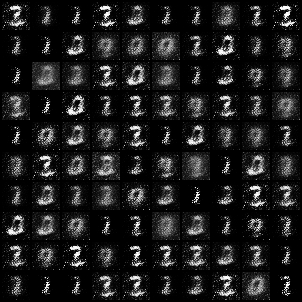

In [44]:
Image('./samples/fake_images-0010.png')

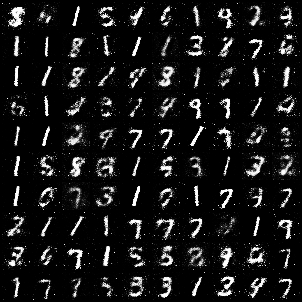

In [45]:
Image('./samples/fake_images-0050.png')

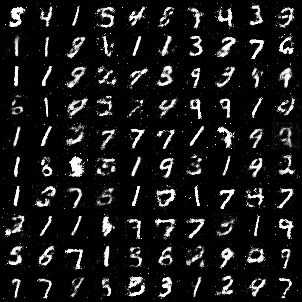

In [46]:
Image('./samples/fake_images-0100.png')

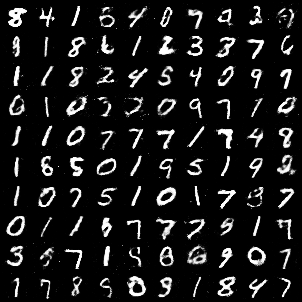

In [47]:
Image('./samples/fake_images-0300.png')

In [49]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

C:\Users\gobis\anaconda3\envs\pytorch\code\06-mnist-gan\gans_training.avi

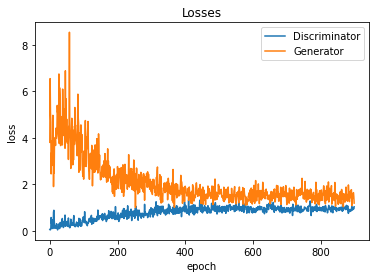

In [50]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

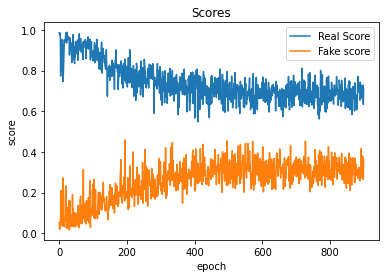

In [51]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

## Save and Commit

In [52]:
# Install the library
!pip install jovian --upgrade -q

In [53]:
# Import the library
import jovian

In [54]:
jovian.commit(outputs=['samples/fake_images-0000.png', 
                       'samples/fake_images-0010.png', 
                       'samples/fake_images-0025.png', 
                       'samples/fake_images-0050.png', 
                       'samples/fake_images-0100.png', 
                       'samples/fake_images-0150.png', 
                       'samples/fake_images-0200.png', 
                       'samples/fake_images-0250.png', 
                       'samples/fake_images-0300.png', 
                       'gans_training.avi'], 
              project='06-mnist-gan')

<IPython.core.display.Javascript object>

[jovian] Creating a new project "gopirevathisreenivasan/06-mnist-gan"
[jovian] Uploading additional outputs...
[jovian] Committed successfully! https://jovian.ai/gopirevathisreenivasan/06-mnist-gan


'https://jovian.ai/gopirevathisreenivasan/06-mnist-gan'